In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def Sun_time(files_dir):
    # get Sunrise and Sunset time
    df = pd.read_excel(files_dir)
    df = df.loc[(df['Year'] >= 2017) &(df['Year'] <= 2020)] 
    df['SolarNoon'] = (df['Sunrise']+df['Sunset'])/2 # calculate the solar noon time
    # df =  df.loc[:, ['Year', 'Month', 'Day','Sunrise','Sunset','SolarNoon']]
    df =  df.loc[:, ['Year', 'Month', 'Day','SolarNoon']]
    return df

In [4]:
def SolarData(files_dir):
    df = pd.read_excel(files_dir)
    df = df.loc[(df['Year'] >= 2017) &(df['Year'] <= 2020)]
    
    df['Date'] =  df['DateTime'].dt.date
    #df.index = df['DateTime']
    #del df['DateTime']
    
    # Add a Hot Panel Variable
    count = round(len(df)* 0.01)
    GGHI = df.sort_values(by = ['GHI'], ascending = False).reset_index(drop = True)
    GGHI = GGHI.iloc[:count]
    GGHI = GGHI[len(GGHI)-1:]['GHI'].values[0]
    df['Hot_Panel'] = df.apply(lambda x:1 if (x.GHI>=GGHI and x._THI>70) else(0), axis=1)
    
     # Add a ClearSky_Ratio Variable
#     df['ClearSky_Ratio'] = df.apply(lambda x:x['GHI']/x['GHI_TOA'] if (x['GHI_TOA']>10 and x['GHI']>10) else(0), axis=1)

    return df

In [5]:
def merge(df1, df2):
    df = pd.merge(df2, df1, on = ['Year', 'Month','Day']) 
    df = df.dropna(axis=0, how='any', inplace=False)
    df['Suntime'] = df['Hour']-df['SolarNoon']
    df.index = df['DateTime']
    del df['DateTime']
    return df

In [6]:
files_dir = "C:/Users/zhongj/Desktop/Task2_Data/Sun_Info/Sun_Info_zone_K.xlsx" 
df1 = Sun_time(files_dir)

In [7]:
files_dir2 = "C:/Users/zhongj/Desktop/Task2_Data/Final_Zonal_Data_for_Modeling" 
os.chdir(files_dir2)
df2 = SolarData('ZoneK_FinalData.xlsx')

In [8]:
df = merge(df1, df2)

In [9]:
files_dir3 = "C:/Users/zhongj/Desktop/Task2_Results/Correlation_Hourly" 
os.chdir(files_dir3)

In [10]:
def corr(df, variables, HR):
    #choose data and time range:
    n = len(variables)
    Zone_name = list(df['Zone'].unique())[0] #Zone name
    cor_data = df.loc[:, variables]
    cor_data = cor_data.loc[(df['Hour'] == HR)]
    
    #plot:
    g = sns.PairGrid(cor_data, aspect=1.4, diag_sharey=False)
    g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'}) #lower triangle
    g.map_diag(sns.distplot, kde_kws={'color': 'black'}) #diagonal
    # g.map_upper(corrdot) #upper triangle
    
    #title:
    g.fig.suptitle('Zone%s Scatter Plots at Hr%d'%(Zone_name, HR), y=1.08)

    plt.savefig('Zone%s Scatter Plots at Hr%d'%(Zone_name, HR), bbox_inches="tight")
    plt.show()
   
    plt.cla()
    plt.clf()

In [11]:
def corr_hm(df, variables, HR):
    n = len(variables)
   
    Zone_name = list(df['Zone'].unique())[0] #Zone name
    
    #choose data and time range
    cor_data =  df.loc[:, variables]
    cor_data = cor_data.loc[(df['Hour'] == HR)]
    
    #setting:
    plt.figure(figsize=(25,10))
    plt.title('Zone%s Correlation Heatmap at hour%d'%(Zone_name, HR))
    
    #plot:
    correlation_mat = cor_data.corr()
    upp_mat = np.triu(correlation_mat)
    sns.heatmap(correlation_mat, annot = True, cmap="RdYlGn_r",mask = upp_mat)

    plt.savefig('Zone%s Correlation Heatmap at hour%d'%(Zone_name, HR), 
                bbox_inches="tight")
    plt.show()
    
    plt.cla()
    plt.clf()

In [ ]:
for HR in range(7,19):
    variables1 = ['GHI','_CLC', '_SSM','_THI', '_WCI', '_WDR', '_WSP', 'Declination_LAT', 'Suntime','BTM']
    corr(df, variables1, HR)
    
for HR in range(5,21):    
    variables2 = ['BTM','GHI', 'POA20', 'POA30',
                  '_CLC', '_DBT60', '_DEW', '_SSM',
                  '_THI', '_WCI', '_WDR', '_WET', '_WSP', 'Declination_LAT',
                  'ClearSky_Delta', 'Hot_Panel', 'Suntime']
    corr_hm(df, variables2, HR)


In [ ]:
df['CLC1'] = df.apply(lambda x:1 if (x['_CLC'] <=20) else(0), axis=1)
df['CLC2'] = df.apply(lambda x:1 if (x['_CLC'] >20 and x['_CLC'] <= 40) else(0), axis=1)
df['CLC3'] = df.apply(lambda x:1 if (x['_CLC'] >40 and x['_CLC'] <= 70) else(0), axis=1)
df['CLC4'] = df.apply(lambda x:1 if (x['_CLC'] >70) else(0), axis=1)

for i in range(1,5):
    df['CLC_GHI%d'%i] = df['CLC%d'%i]*df['GHI']
    del df['CLC%d'%i] 

In [19]:
## add 12 variables: Monthly binary* ClearSky_Delta
df['Month'] = df.apply(lambda x:x['Month'] if (x['Day']>15) else(x['Month']-1), axis=1)
df['Month'] = df['Month'].apply(lambda x:12 if (x == 0) else(x))

for i in range(1,13):
    df['Month%d'%i] = df.apply(lambda x:1 if (x['Month'] == i) else(0), axis=1)
    
for i in range(1,13):
    df['Month%d_ClearSky_Delta'%i] = df['Month%d'%i]*df['ClearSky_Delta']
    del df['Month%d'%i] 

In [39]:
files_dir3 = "C:/Users/zhongj/Desktop/Correlation3" 
os.chdir(files_dir3)

TypeError: Cannot cast array data from dtype('int64') to dtype('int32') according to the rule 'safe'

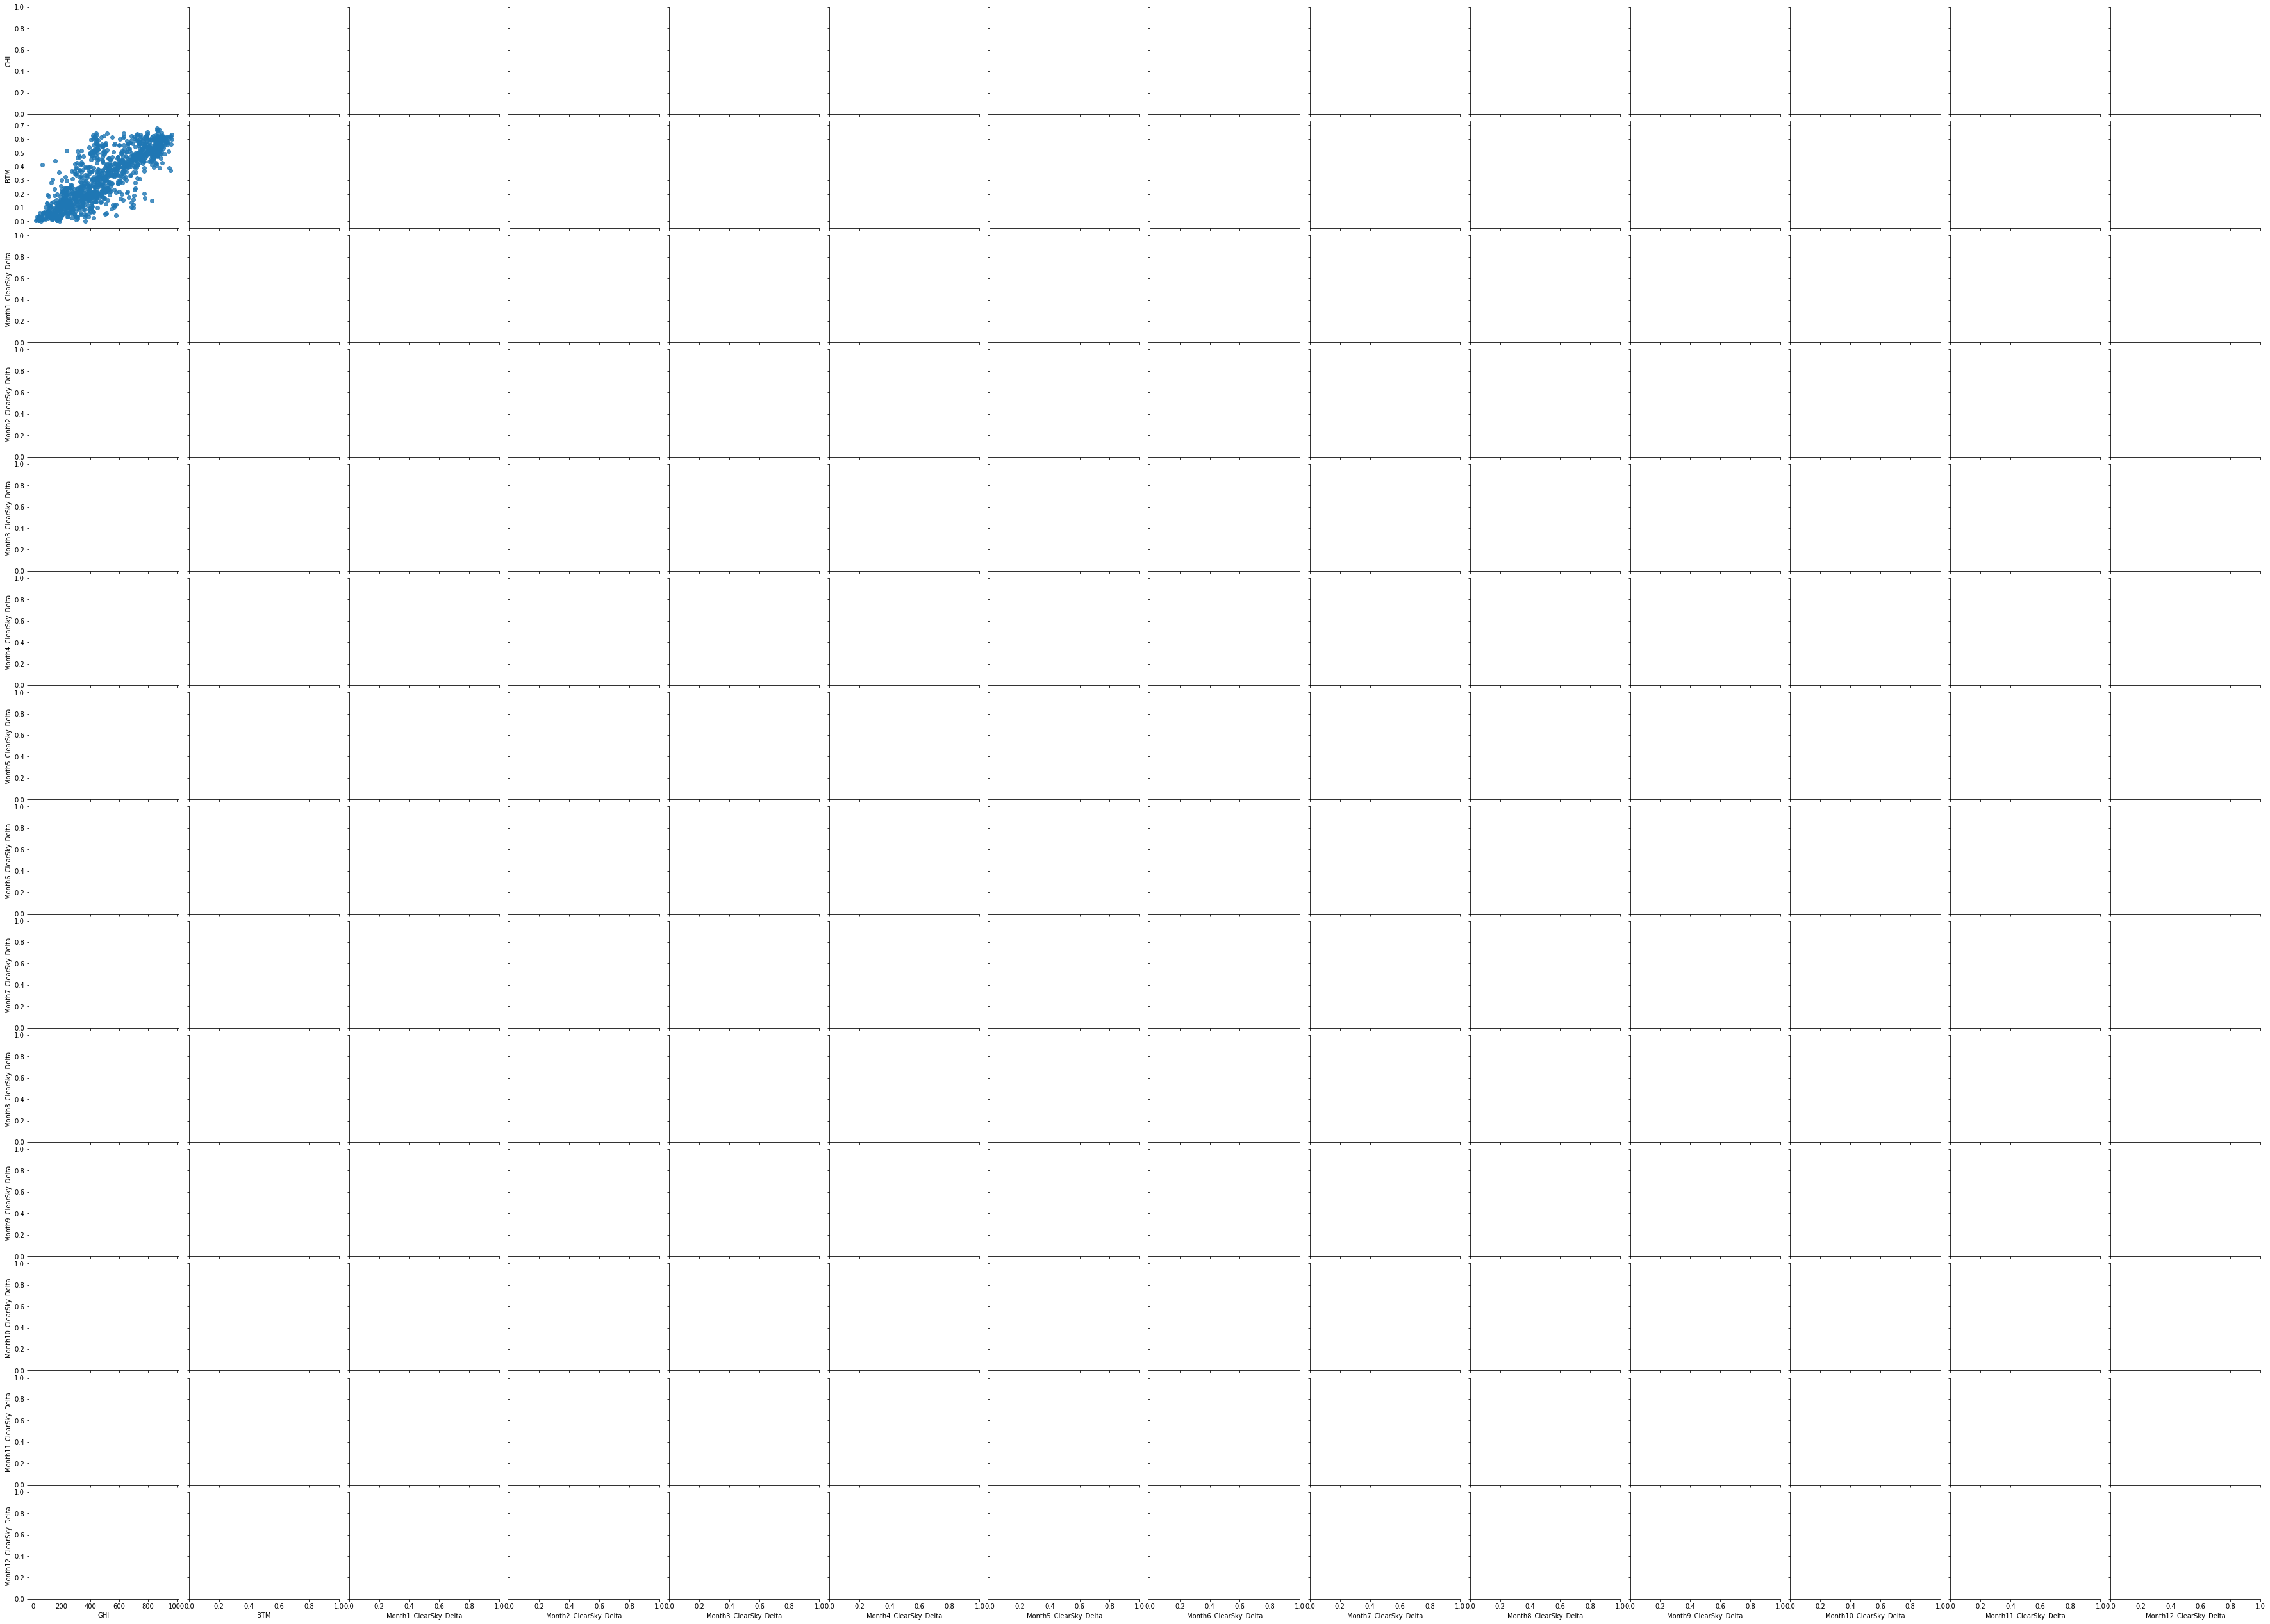

In [40]:
for HR in range(12, 13):
    variables1 = ['GHI', 'BTM','Month1_ClearSky_Delta','Month2_ClearSky_Delta','Month3_ClearSky_Delta',
                  'Month4_ClearSky_Delta','Month5_ClearSky_Delta','Month6_ClearSky_Delta','Month7_ClearSky_Delta',
                  'Month8_ClearSky_Delta','Month9_ClearSky_Delta','Month10_ClearSky_Delta','Month11_ClearSky_Delta',
                  'Month12_ClearSky_Delta']
    corr(df, variables1, HR)